In [19]:
import matplotlib.pyplot as plt 
from CoolProp.CoolProp import PropsSI
import CoolProp.CoolProp as CP

import numpy as np
import pandas as pd


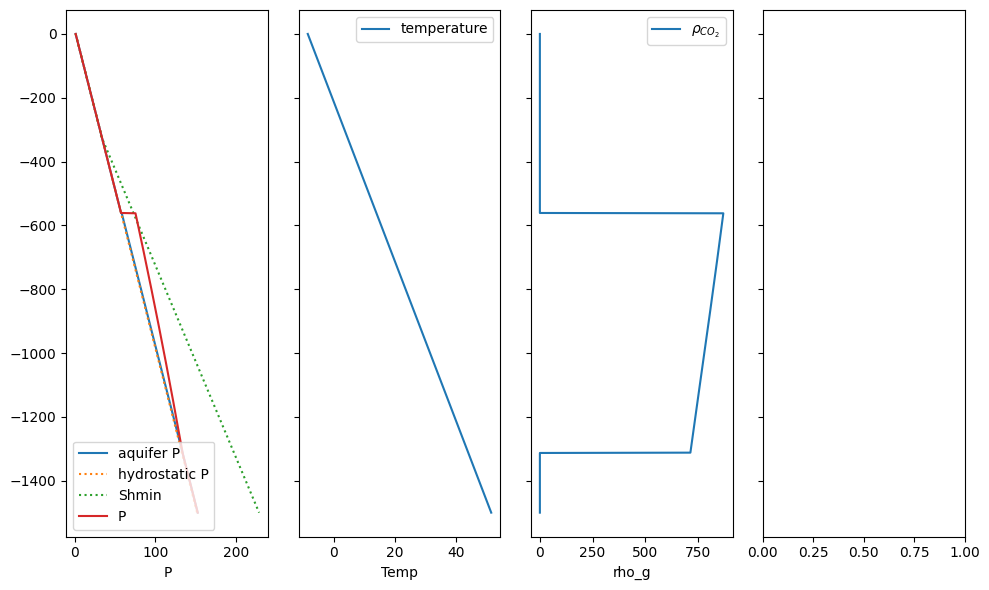

In [22]:
# atmospheric pressure
P_atm = 101325 / 1e5 # bar


Z_sf = -312 #seafloor depth [m]


# reservoir aquifer pressure
aq_P = 60 # bar
aq_P = 124

# reservoir reference depth
aq_Z = -1217 # mTVDMSL

# injection pointo r base of CO2 column
base_CO2_Z = -1312 # m

# base of cement plug/barrier
barrier_Z = -562

#density brine
rho_brine = 1024 # kg/m3

#gravity acceleration
G_acc = 9.8067 # m/s2

#Create depth vector
top = 0
base = 1500

z = -np.linspace(top, base, 1+(base-top))
df = pd.DataFrame(data={'depth':z})

fluid = 'CO2'


def P_aquifer(z, ref_Z, ref_P, rho = 1024, g = 9.8067):
    """
    Creates a hydrostatic gradient based on a given density that matches a reference pressure, depth point
    """

    P_offset = ref_P*1e5 + ref_Z*rho*g
    P = (-(z*g*rho) + P_offset) / 1e5
    return P

#Hydrostatic gradient



df['P_aq'] = P_aquifer(z=z, ref_P=aq_P, ref_Z=aq_Z)
df['P_hyd'] = P_atm-(df['depth']*rho_brine*G_acc)/1e5

df['Sh_min'] = df['P_hyd']
df.loc[df.depth<Z_sf, 'Sh_min'] = -(Z_sf*rho_brine*G_acc)/1e5 - 0.166*(df.loc[df.depth<Z_sf, 'depth']-Z_sf)

df


df.loc[df.depth>barrier_Z, 'P_aq'] =  df.loc[df.depth>barrier_Z, 'P_hyd']
df.loc[df.P_aq < P_atm, 'P_aq'] = 0

#Temperature
Tgrad = 40/1000 #thermal gradient [m/degC]
T_sf = 4 #seafloor temperature [degC]

df['Temp'] = T_sf - (df['depth']-Z_sf)*Tgrad #geothermal temperature field






# hydrostatic pressure at CO2 base
base_CO2_Phyd = P_aquifer(z=base_CO2_Z, ref_P=aq_P, ref_Z=aq_Z)

# hydrostatic pressure at barrier base
barrier_Phyd = P_aquifer(z=barrier_Z, ref_P=aq_P, ref_Z=aq_Z)

#vertical height between base of CO2 and base of barrier
col_CO2_height = barrier_Z - base_CO2_Z

# CO2 column
df['CO2_h'] = df['depth'] - base_CO2_Z
df.loc[(df['CO2_h']<0) | (df['CO2_h']>col_CO2_height), 'CO2_h'] = 0

# delta z
df['dz'] = df.depth.diff()

# create a column for P
df['P'] = df['P_aq']

# create a column for Pcap
df['dPcap'] = 0
df['Pcap'] = 0
df['rho_g'] = 0
df['phase'] = ''




query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')


for idx, row in query.iloc[::-1].iterrows():

    col_h  = row.CO2_h
    z = row.depth
    dz = row.dz
    T = row.Temp
    P_aq = row.P_aq

    if col_h == 0:
        P = P_aq
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid)

        df.loc[idx, 'rho_g'] = rho_g
        Pcap = 0
        P_previous = P
    else:
        dPcap = -((rho_brine - rho_g)*dz*G_acc)/1e5


        Pcap += dPcap

        df.loc[idx, 'dPcap'] = dPcap
        df.loc[idx, 'Pcap'] = Pcap

        P = P_aq + Pcap



        df.loc[idx, 'P'] = P
        
        
        
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid)

        # try:
        #     rho_g = PropsSI("D", "P", P*1e5, "T|gas", T+273.15, fluid)
        # except:
        #     rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid)


        phase = CP.PhaseSI("P", P*1e5, "T", T+273.15, fluid)

        

        df.loc[idx, 'rho_g'] = rho_g
        df.loc[idx, 'phase'] = phase

        rho_previous = rho_g
        
            




fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey=True, figsize=(10, 6))

df.plot(x='P_aq', y='depth', ax= ax1, label='aquifer P')
df.plot(x='P_hyd', y='depth', ax= ax1, label='hydrostatic P', linestyle=':')
df.plot(x='Sh_min', y='depth', ax= ax1, label='Shmin', linestyle=':')


df.plot(x='P', y='depth', ax= ax1, label='P')
# ax1.plot(PFT['pressure'], -PFT['depth'], ls=':')

df.plot(x='Temp', y='depth', ax= ax2, label='temperature')
df.plot(x='rho_g', y='depth', ax= ax3, label=r'$\rho_{CO_2}$')



# ax3.plot(rho_g_0, df.depth, '--')
# ax3.plot(rho_g_f, df.depth, '--')
# ax3.plot(PFT['rhog'], -PFT['depth'])


# ax4.plot(PFT['sgas'], -PFT['depth'])


ax1.legend(loc='lower left')

fig.tight_layout()


In [21]:
query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')
query

,depth,P_aq,P_hyd,Sh_min,Temp,CO2_h,dz,P,dPcap,Pcap,rho_g,phase
562,-562.0,0.000000,57.449632,72.83123,14.00,750.0,-1.0,53.820204,0.018289,53.820204,837.936927,liquid
563,-563.0,0.000000,57.550052,72.99723,14.04,749.0,-1.0,53.801915,0.018332,53.801915,837.502161,liquid
564,-564.0,0.000000,57.650473,73.16323,14.08,748.0,-1.0,53.783582,0.018375,53.783582,837.066027,liquid
565,-565.0,0.000000,57.750894,73.32923,14.12,747.0,-1.0,53.765207,0.018418,53.765207,836.628511,liquid
566,-566.0,0.000000,57.851314,73.49523,14.16,746.0,-1.0,53.746789,0.018461,53.746789,836.189602,liquid
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,-1308.0,69.138275,132.363405,196.66723,43.84,4.0,-1.0,69.467949,0.082416,0.329673,183.611623,supercritical_gas
1309,-1309.0,69.238696,132.463826,196.83323,43.88,3.0,-1.0,69.485953,0.082418,0.247257,183.595436,supercritical_gas
1310,-1310.0,69.339117,132.564246,196.99923,43.92,2.0,-1.0,69.503956,0.082419,0.164840,183.579277,supercritical_gas
1311,-1311.0,69.439537,132.664667,197.16523,43.96,1.0,-1.0,69.521958,0.082421,0.082421,183.563147,supercritical_gas


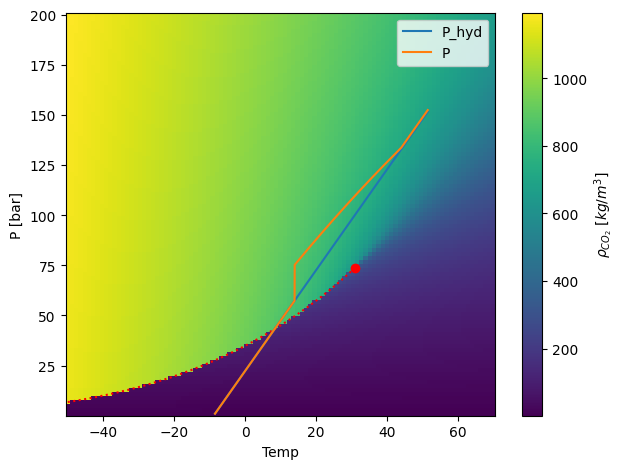

In [23]:
nx, ny = (101, 101)
T = np.linspace(-50, 70, nx)

P = np.linspace(1, 200, ny)
Tv, Pv = np.meshgrid(T, P)



Tv = Tv.flatten()
Pv = Pv.flatten()

density_coolprop = PropsSI("D", "P", Pv*1e5, "T", Tv+273.15, "CO2")



Pcrit = PropsSI('CO2', 'pcrit')
Tcrit = PropsSI('CO2', 'Tcrit')

Tphase = np.linspace(273.15-50, Tcrit, 2000)
Pphase = PropsSI('P','T',Tphase,'Q',0,'CO2')

Tv = Tv.reshape(nx, ny)
Pv = Pv.reshape(nx, ny)
density_coolprop = density_coolprop.reshape(nx, ny)

fig, ax = plt.subplots()

pcm = ax.pcolormesh(Tv, Pv, density_coolprop, shading='nearest')

ax.scatter(Tcrit-273.15, Pcrit/1e5, c='red', label='critical P,T')
ax.plot(Tphase-273.15, Pphase/1e5, c='red', ls=':')
ax.set_xlabel('T [$\degree$C]')
ax.set_ylabel('P [bar]')

df.plot(x='Temp', y='P_hyd', ax=ax)
df.plot(x='Temp', y='P', ax=ax)

fig.colorbar(pcm, label = r'$\rho_{CO_2}$ [$kg/m^3$]')

fig.tight_layout()

# fig.savefig('CO2_density.png')


In [6]:
nx, ny = (101, 101)
T = np.linspace(-50, 70, nx)

P = np.linspace(1, 200, ny)
Tv, Pv = np.meshgrid(T, P)



Tv = Tv.flatten()
Pv = Pv.flatten()

fluid = 'HEOS::CO2[0.98]&Ar[0.02]'

# density_coolprop = PropsSI("D", "P", Pv*1e5, "T", Tv+273.15, fluid)



Pcrit = PropsSI(fluid, 'pcrit')
Tcrit = PropsSI(fluid, 'Tcrit')

Tphase = np.linspace(273.15-50, Tcrit, 2000)
Pphase = PropsSI('P','T',Tphase,'Q',0,fluid)

Tv = Tv.reshape(nx, ny)
Pv = Pv.reshape(nx, ny)
# density_coolprop = density_coolprop.reshape(nx, ny)

fig, ax = plt.subplots()

# pcm = ax.pcolormesh(Tv, Pv, density_coolprop, shading='nearest')

ax.scatter(Tcrit-273.15, Pcrit/1e5, c='red', label='critical P,T')
ax.plot(Tphase-273.15, Pphase/1e5, c='red', ls=':')
ax.set_xlabel('T [$\degree$C]')
ax.set_ylabel('P [bar]')


fig.colorbar(pcm, label = r'$\rho_{CO_2}$ [$kg/m^3$]')

fig.tight_layout()

# fig.savefig('CO2_density.png')


ValueError: Unable to use input parameter [pcrit] in Props1SI for fluid HEOS::CO2[0.98]&Ar[0.02]; error was No outputs were able to be calculated : PropsSI("pcrit","",0,"",0,"HEOS::CO2[0.98]&Ar[0.02]") :: inputs were :"HEOS::CO2[0.98]&Ar[0.02]","pcrit"

In [9]:
CP.get_global_param_string('predefined_mixtures').split(',')

['AIR.MIX',
 'AMARILLO.MIX',
 'Air.mix',
 'Amarillo.mix',
 'EKOFISK.MIX',
 'Ekofisk.mix',
 'GULFCOAST.MIX',
 'GULFCOASTGAS(NIST1).MIX',
 'GulfCoast.mix',
 'GulfCoastGas(NIST1).mix',
 'HIGHCO2.MIX',
 'HIGHN2.MIX',
 'HighCO2.mix',
 'HighN2.mix',
 'NATURALGASSAMPLE.MIX',
 'NaturalGasSample.mix',
 'R401A.MIX',
 'R401A.mix',
 'R401B.MIX',
 'R401B.mix',
 'R401C.MIX',
 'R401C.mix',
 'R402A.MIX',
 'R402A.mix',
 'R402B.MIX',
 'R402B.mix',
 'R403A.MIX',
 'R403A.mix',
 'R403B.MIX',
 'R403B.mix',
 'R404A.MIX',
 'R404A.mix',
 'R405A.MIX',
 'R405A.mix',
 'R406A.MIX',
 'R406A.mix',
 'R407A.MIX',
 'R407A.mix',
 'R407B.MIX',
 'R407B.mix',
 'R407C.MIX',
 'R407C.mix',
 'R407D.MIX',
 'R407D.mix',
 'R407E.MIX',
 'R407E.mix',
 'R407F.MIX',
 'R407F.mix',
 'R408A.MIX',
 'R408A.mix',
 'R409A.MIX',
 'R409A.mix',
 'R409B.MIX',
 'R409B.mix',
 'R410A.MIX',
 'R410A.mix',
 'R410B.MIX',
 'R410B.mix',
 'R411A.MIX',
 'R411A.mix',
 'R411B.MIX',
 'R411B.mix',
 'R412A.MIX',
 'R412A.mix',
 'R413A.MIX',
 'R413A.mix',
 'R414

In [15]:

CP.get_fluid_param_string("EKOFISK.MIX", 'formula')

'C_{1}H_{4}'

In [18]:
for k in ['formula','CAS','aliases','ASHRAE34','REFPROP_name','pure','INCHI','INCHI_Key','CHEMSPIDER_ID']:
    item = k + ' --> ' + CP.get_fluid_param_string("HighCO2.mix", k)
    print(item)

formula --> C_{1}H_{4}
CAS --> 74-82-8
aliases --> CH4,methane,METHANE,R50,n-C1H4
ASHRAE34 --> A3
REFPROP_name --> METHANE
pure --> false
INCHI --> InChI=1S/CH4/h1H4
INCHI_Key --> VNWKTOKETHGBQD-UHFFFAOYSA-N
CHEMSPIDER_ID --> 291


In [ ]:
CP.get_parameter_information